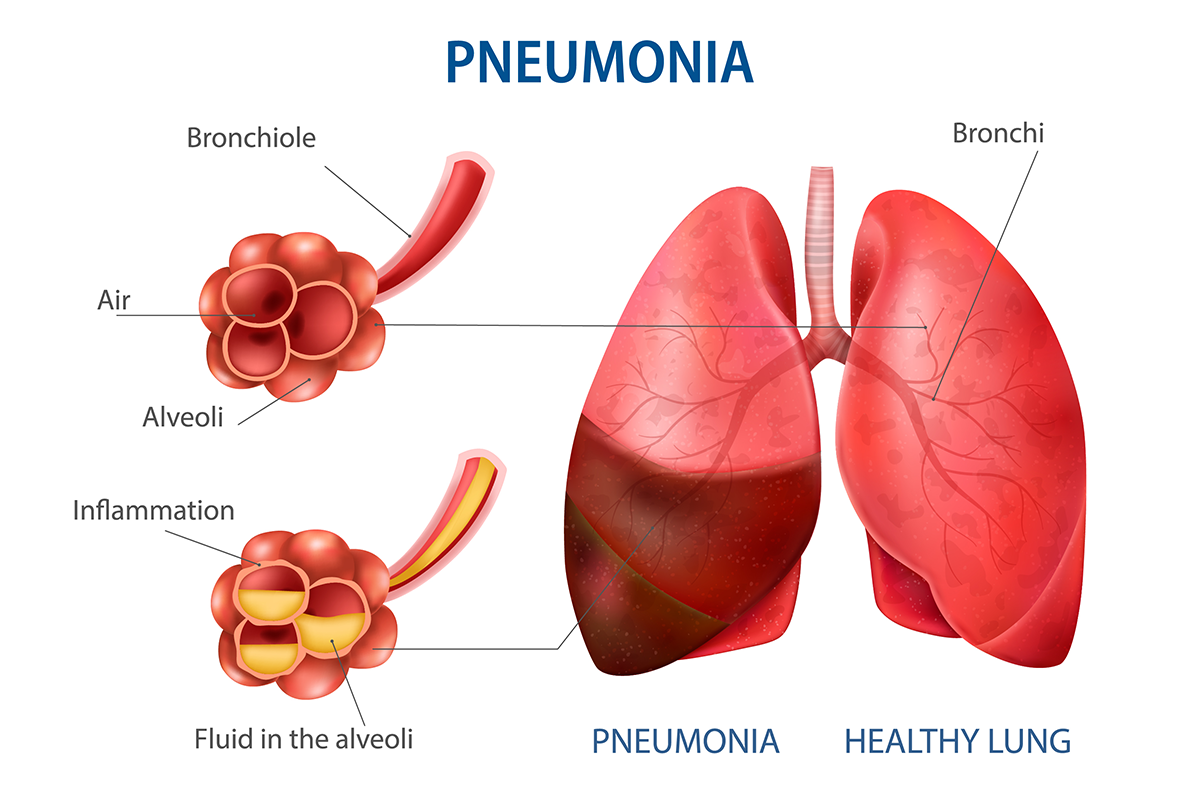

Pneumonia is a serious medical condition that affects the lungs, leading to inflammation and difficulty in breathing. It is one of the leading causes of death worldwide, especially in young children, the elderly, and those with weakened immune systems. Early detection and treatment are critical in improving outcomes and preventing severe complications.

### What is Pneumonia? 🫁

Pneumonia is an infection that inflames the air sacs (alveoli) in one or both lungs. It can be caused by bacteria, viruses, or fungi. The infection causes fluid or pus to accumulate in the lungs, which can lead to symptoms such as:

- **Cough** (sometimes with mucus)
- **Shortness of breath** or difficulty breathing
- **Chest pain**
- **Fever** and chills
- **Fatigue** and weakness

While pneumonia can be treated with antibiotics or antivirals (depending on the cause), it can become life-threatening if not diagnosed and treated promptly. For this reason, **early detection** is extremely important.

### Why Early Detection is Crucial? ⏰

Early detection of pneumonia can significantly reduce the risk of complications like respiratory failure, sepsis, or even death. Traditionally, diagnosing pneumonia involves a combination of clinical symptoms, physical exams, and **X-ray imaging**. However, **manual interpretation** of X-ray images can be slow, subjective, and prone to human error—especially in areas with limited healthcare resources.

This is where **deep learning** comes into play! By using advanced **Convolutional Neural Networks (CNNs)**, we can automate the process of pneumonia detection from X-ray images, assisting healthcare professionals in making faster, more accurate diagnoses.

### Our Approach: Automated Pneumonia Detection with Deep Learning 🤖

In this notebook, we will build a **Convolutional Neural Network (CNN)** to classify X-ray images into two categories:
- **PNEUMONIA** 🦠
- **NORMAL** ✅

CNNs are a class of deep learning models that excel at analyzing images, detecting patterns, and learning features at different levels of abstraction. Here's how we approach the problem:

1. **Data Preprocessing and Augmentation** 🌱: 
   - We'll load the dataset of X-ray images and apply **data augmentation** techniques like random rotations, flips, and scaling to artificially expand the dataset. This helps the model generalize better and prevents it from overfitting to the training data.

2. **Model Architecture** 🏗️:
   - We will design a CNN architecture that includes several layers like convolutional layers, pooling layers, dropout layers, and fully connected layers. This model will learn to differentiate between **PNEUMONIA** and **NORMAL** X-ray images.
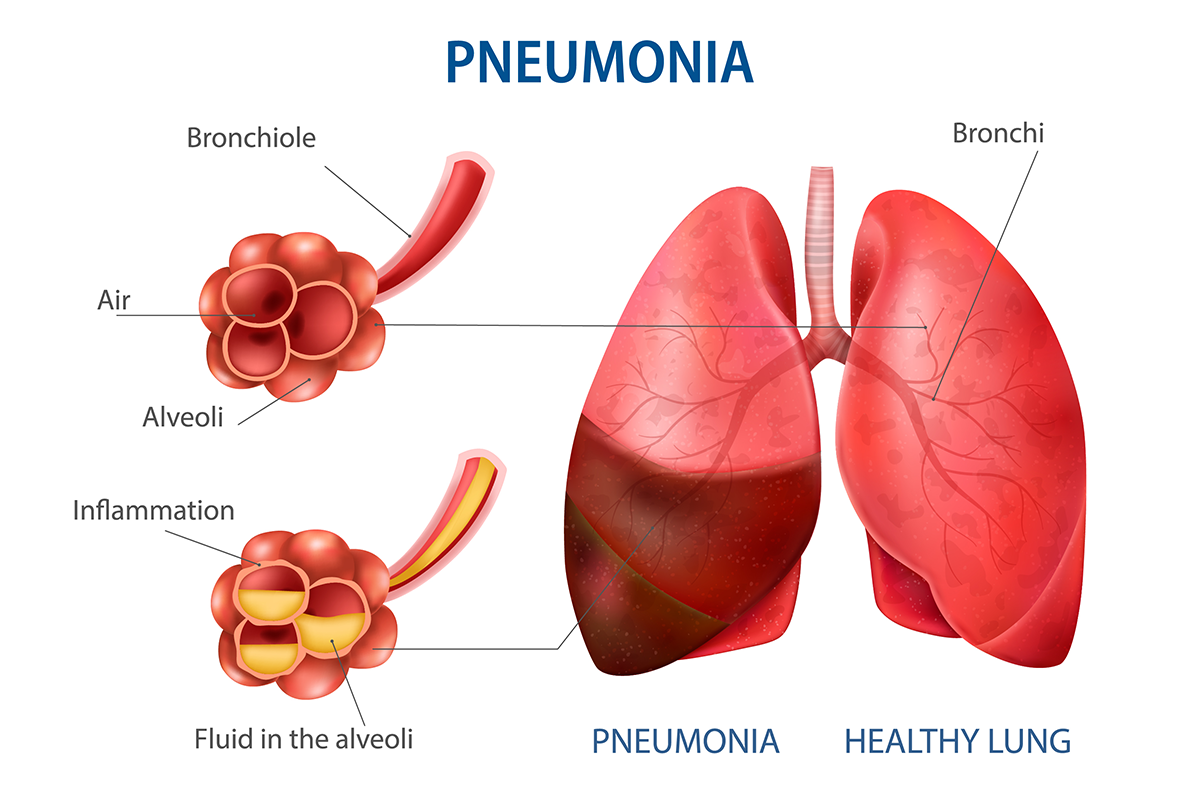

## **Initialising Project**

In [42]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm 
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

Before we begin loading and preprocessing the data, we define a few **important constants and paths** that will be used throughout the notebook.

- `img_size = 150`: This sets the size to which all X-ray images will be resized (150x150 pixels). A consistent image size is important so that they can be fed into the neural network.
- `batch_size = 32`: This determines how many images the model processes at once during training. A batch size of 32 is a good balance between speed and stability.

In [3]:
# Constants
img_size = 150
batch_size = 32

# Paths (adjust if needed)
base_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

## **Normal v/s Infected Lungs**

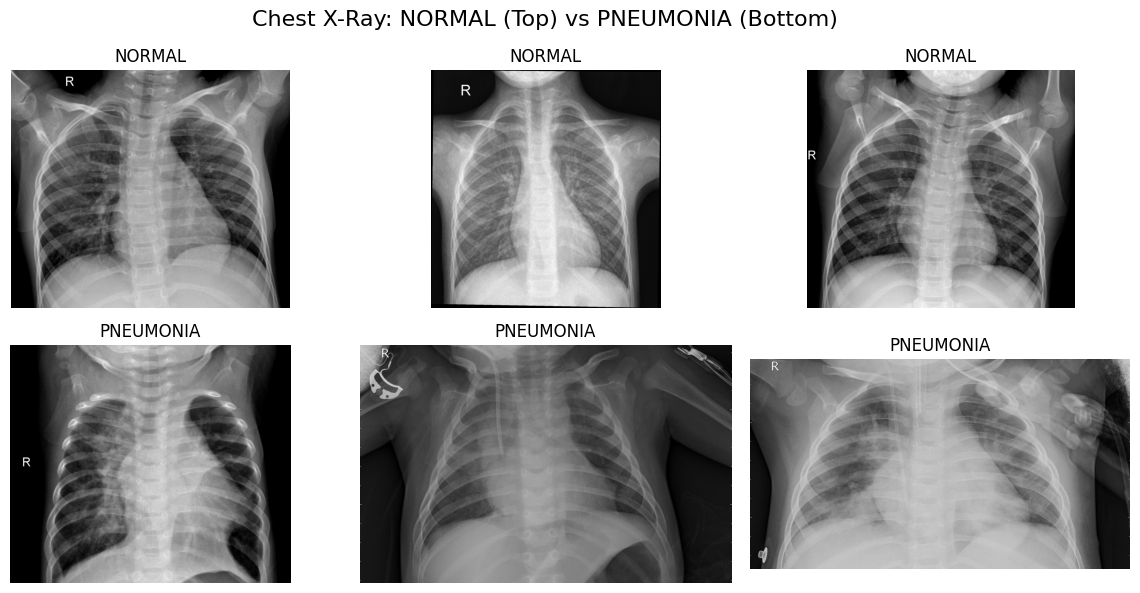

In [44]:
# Directories
normal_scans_dir = os.path.join(train_dir, "NORMAL")
infected_scans_dir = os.path.join(train_dir, "PNEUMONIA")

# Randomly select 3 images from each category
normal_images = random.sample(
    [os.path.join(normal_scans_dir, f) for f in os.listdir(normal_scans_dir)], 3
)
infected_images = random.sample(
    [os.path.join(infected_scans_dir, f) for f in os.listdir(infected_scans_dir)], 3
)

# Set up plot
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle('Chest X-Ray: NORMAL (Top) vs PNEUMONIA (Bottom)', fontsize=16)

# Plot NORMAL images
for i, img_path in enumerate(normal_images):
    img = Image.open(img_path)
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("NORMAL")

# Plot PNEUMONIA images
for i, img_path in enumerate(infected_images):
    img = Image.open(img_path)
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("PNEUMONIA")

plt.tight_layout()
plt.show()


## **Preparing Dataset**

## 1. **Transforms** 🖼️
The transforms applied to the images are designed to standardize and prepare the data for training:

- **`Grayscale()`**: Converts images to grayscale, reducing complexity by focusing only on intensity rather than color. This is helpful in medical imaging, where color might not be as significant as texture or intensity (e.g., in X-rays).
  
- **`Resize()`**: Ensures all images have the same dimensions (150x150). Consistency in input size is crucial for neural networks to process the data correctly.

- **`ToTensor()`**: Converts the image from a range of `[0, 255]` (as pixel values) to `[0.0, 1.0]` for better training performance. Neural networks work best with normalized inputs, and converting to tensors is necessary for feeding the data into PyTorch models.

- **`Normalize()`**: Standardizes the pixel values to a specific range (mean=0.5, std=0.5). This step makes the data distribution more uniform, helping the model converge faster during training.


### 2. **DataLoader** 🛠️

**`DataLoader`** plays a key role in efficiently handling the dataset during training:

- **Batching**: Loading data in small batches rather than all at once helps the model train faster and with less memory usage. It also allows us to update the model’s weights more frequently, which can speed up convergence.
  
- **Shuffling**: Shuffling during training ensures that the model doesn't learn any bias or patterns from the order of the data. It prevents the model from memorizing specific sequences, helping improve generalization.

- **Separate Loaders for Training, Validation, and Testing**: 
  - **Training (`train_loader`)**: Shuffling helps introduce randomness, reducing overfitting.
  - **Validation (`val_loader`) and Test (`test_loader`)**: Data is loaded without shuffling to maintain consistency in performance evaluation.

In [28]:
# Transforms (grayscale, resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Grayscale(),  # Converts to 1 channel
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),  # [0,255] → [0.0,1.0], and HWC → CHW
    transforms.Normalize(mean=[0.5], std=[0.5])  # Example normalization
])

# Function to create DataLoaders from train/test/val folders
def get_dataloader(data_dir, batch_size=32, shuffle=True):
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader, dataset

# Get loaders and datasets
train_loader, train_dataset = get_dataloader(train_dir, batch_size=batch_size, shuffle=True)
val_loader, val_dataset = get_dataloader(val_dir, batch_size=batch_size, shuffle=False)
test_loader, test_dataset = get_dataloader(test_dir, batch_size=batch_size, shuffle=False)

### 1. **Convolutional Layers** (Feature Extraction)

- **`nn.Conv2d`**: Applies convolutional filters to the image to extract features. Each layer increases the number of channels (filters), capturing progressively more complex features of the image.
  - The input to the network has **1 channel** (grayscale image), and the filters start at **32** and increase in subsequent layers.
  - The kernel size of `3x3` is a common choice as it captures local spatial features effectively.
  - **`padding=1`** ensures that the spatial dimensions (height and width) of the image are preserved after the convolution operation (i.e., the output image size is the same as the input size).

- **Activation Function - `ReLU`**: After each convolution, **ReLU** (Rectified Linear Unit) activation is applied, which introduces non-linearity into the model and helps it learn complex patterns.

- **Batch Normalization - `nn.BatchNorm2d`**: Normalizes the output of each convolutional layer, speeding up training and helping to reduce overfitting by stabilizing the learning process.

- **Pooling - `nn.MaxPool2d`**: Max pooling reduces the spatial dimensions (height and width) of the feature maps while retaining important features, making the network computationally more efficient.

- **Dropout - `nn.Dropout`**: Regularization technique that randomly disables a fraction of the neurons during training to reduce overfitting. This is applied in some of the layers to prevent the model from memorizing specific patterns in the data.

### 2. **Fully Connected Layers** (Classification)

- **`nn.Flatten`**: After the convolutional and pooling layers, the output is flattened into a 1D vector to be fed into fully connected (dense) layers.

- **`nn.Linear`**: Fully connected layers that output a score. The first dense layer has 128 units, followed by a **ReLU** activation to introduce non-linearity. The final output layer has **1 unit** for binary classification (pneumonia vs normal), with a **Sigmoid** activation function that outputs a probability between 0 and 1.

### 3. **Binary Classification**

- The output is passed through a **Sigmoid** activation function to obtain a probability for binary classification (pneumonia or normal). The final output will be **close to 1 for pneumonia** and **close to 0 for normal**.

---

### Model Summary:

1. **Layer Structure**:
   - 5 convolutional blocks (with increasing depth: 32, 64, 128, 256)
   - Dropout layers to combat overfitting
   - Batch normalization to stabilize learning
   - Final output layer for binary classification

2. **Forward Pass**:
   - Images are passed through each layer sequentially (convolution, activation, pooling, dropout, etc.) before being flattened and passed through the fully connected layers.
   - The final layer produces a probability score for the two classes (pneumonia or normal).

In [30]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # same as padding='same'
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 128),  # based on 150x150 input size
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),  # Binary classification
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### **Model Setup**

- **`nn.BCELoss()`** (Binary Cross-Entropy Loss) is the loss function used for binary classification tasks.
- Since the model outputs a probability between 0 and 1 (via the **Sigmoid** activation function), BCELoss is appropriate for this kind of problem, comparing the predicted probability with the actual class labels (0 or 1).
- **`optim.RMSprop()`** is an optimizer that adjusts the learning rate based on the gradients and helps in faster convergence.
- **`model.parameters()`** passes the model parameters (weights and biases) to the optimizer so it can update them during training.
- The **learning rate (`lr`)** of 0.001 is a common starting point, but it may be adjusted based on the model's performance.

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PneumoniaCNN().to(device)

criterion = nn.BCELoss()  # Because output is sigmoid (between 0 and 1)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

#### **How the Training Process Works**
1. **Epoch Iteration:** The loop runs for several epochs, where each epoch processes the training data and adjusts the model’s parameters.
2. **Batch Processing:** Data is divided into batches. The model processes each batch to compute predictions, calculates loss, and adjusts parameters using **backpropagation**.
3. **Tracking Metrics:** Loss and accuracy are tracked during each epoch, showing the model's progress.
4. **Backward Pass:** Gradients are calculated, and the optimizer updates the model’s parameters to minimize the loss.

In [34]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{(100 * correct / total):.2f}%"
        })

    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] finished → Loss: {running_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1/10


Epoch [1/10] finished → Loss: 265.6666, Accuracy: 90.64%

Epoch 2/10


Epoch [2/10] finished → Loss: 20.2919, Accuracy: 95.46%

Epoch 3/10


Epoch [3/10] finished → Loss: 14.6089, Accuracy: 96.68%

Epoch 4/10


Epoch [4/10] finished → Loss: 11.6745, Accuracy: 97.24%

Epoch 5/10


Epoch [5/10] finished → Loss: 12.2713, Accuracy: 97.53%

Epoch 6/10


Epoch [6/10] finished → Loss: 10.5787, Accuracy: 97.66%

Epoch 7/10


Epoch [7/10] finished → Loss: 7.5208, Accuracy: 98.35%

Epoch 8/10


Epoch [8/10] finished → Loss: 6.5423, Accuracy: 98.75%

Epoch 9/10


Epoch [9/10] finished → Loss: 7.3947, Accuracy: 98.41%

Epoch 10/10


Epoch [10/10] finished → Loss: 5.6974, Accuracy: 98.89%


## **Evaluating**

In [46]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 87.25%
